In [1]:
# Install package
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install ipympl

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl (914 kB)


In [2]:
#%matplotlib widget 

import numpy as np
import matplotlib.pyplot as plt
from time import time
import random
import sklearn
from mpl_toolkits.mplot3d import Axes3D 

1) Device Type:

Choose a device type (Lights, Camera, Smart Speaker, Thermostat,…) and plot the data

In [3]:
from csv import *
filename = f"smart_home_device_usage_data.csv"

# Open file
with open(filename, mode='r') as file:
    reader = reader(file)
    data = list(reader)  # Convert in list to make all lines accessible 
n = len(data)-1 # number of lines

DeviceType = 'Thermostat' # Camera, Lights, Security System, Smart Speaker, Thermostat
Prefix = DeviceType.replace(" ", "")
count = sum(1 for row in data if len(row) > 1 and row[1] == DeviceType)
print(f"Nombre d'occurrences de l'objet choisi dans la colonne 2 : {count}")

xi_list = np.zeros((count,3)) # three parameters 
yi_list = np.zeros(count) # labels

i = 0
for row in data[1:]:
    
    if row[1] == DeviceType:
        yi_list[i]   = row[7] # label: 0 - Inefficient, 1 - Efficient
        xi_list[i,0] = row[2] # usagehoursperday
        xi_list[i,1] = row[3] # energyconsumption
        xi_list[i,2] = row[6] # DeviceAgeMonths
        i+=1

assert(i == count)
n = i # data number=count

# normalize data (features between [0,1]):
min_values = np.array([0, 0, 0])  # Features minimum
max_values = np.array([25,10, 60])  # Features maximum
x_normalized = (xi_list - min_values) / (max_values - min_values)
xi_list = x_normalized
print(np.shape(x_normalized))

Nombre d'occurrences de l'objet choisi dans la colonne 2 : 1039
(1039, 3)


We are given a family of $n$ points $x_i=(x_i^0, x_i^1, x_i^2)$ in $\mathbb{R}^3$, along with associated labels $(y_i)_{1\leq i\leq n}$ in $\{0,1\}$.

In previous work, we aimed to establish a relationship between $x$ and $y$
in the form:
  * if $\sigma(\langle w,x\rangle)\geq 0.5$, then $y=1$,
  * else $y=0$

where $(w_0,w_1)\in\mathbb{R}^2$ was the unknown of the problem and $\sigma$ was the sigmoid function $z\mapsto\frac{1}{1+e^{-z}}$. Then, for a new unlabeled data $x$, we were computing $\sigma(\langle w,x\rangle)\in[0,1]$, allowing us to classify it as either $y=0$ or $y=1$ while incorporating a measure of uncertainty in the prediction.

To simplify the model, we assumed that the data were centered at $0$ and set the bias term $b=0$: we only had to minimize the log-loss function with respect to the weights.

In general, a bias term $b$ is required, meaning that we introduce an additional parameter $b\in\mathbb{R}$ and seek a relationship of the form:
  * if $\sigma(\langle w,x\rangle+b)\geq 0.5$, then $y=1$,
  * else $y=0$

since there is no reason to assume that the separating hyperplane should pass through the origin.

However, we can eliminate the bias term by increasing the dimensionality from $d$
to $d+1$. In our case, this means increasing the dimensions of both $x$ and $w$ from $3$ to $4$: we redefine

$$
x=(x^0,x^1,x^2,1)\mbox{ and }w=(w^0,w^1,w^2,b)
$$

This transformation allows us to maintain the same matrix notation as before in the optimization step.

The log-loss function without a penalization term is thus given by:

$$
f(w)=-\frac{1}{n}\sum_{i=1}^n\big(y_i\log(\sigma(\langle w,x_i\rangle))+(1-y_i)\log(1-\sigma(\langle w,x_i\rangle))\big)
$$

## Data plot

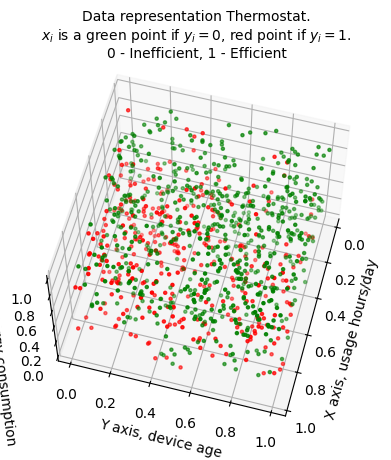

In [4]:
# data plot
from mpl_toolkits.mplot3d import Axes3D
xi_list_bias=np.zeros((n,4)) #increasing dimension from 3 to 4

for i in range(n): #redefining data x in x=(x0,x1,x2,1)
    xi_list_bias[i, 0:3]= xi_list[i]
    xi_list_bias[i, 3]= 1.0

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xi_efficient = np.array([x for i, x in enumerate(xi_list) if yi_list[i] == 1])
xi_inefficient = np.array([x for i, x in enumerate(xi_list) if yi_list[i] == 0])
ax.scatter(xi_efficient[:, 0], xi_efficient[:, 1], xi_efficient[:, 2], color="red", marker=".")
ax.scatter(xi_inefficient[:, 0], xi_inefficient[:, 1], xi_inefficient[:, 2], color="green", marker=".")

elevation_angle = 60
azimuthal_angle = 15
ax.view_init(elevation_angle, azimuthal_angle)


ax.set_xlabel("X axis, usage hours/day")
ax.set_ylabel("Y axis, device age")
ax.set_zlabel("Z axis,  energy consumption")


plt.title(u"Data representation " + DeviceType + ".\n" + r"$x_i$ is a green point if $y_i = 0$, red point if $y_i = 1$."+u"\n"+ r"0 - Inefficient, 1 - Efficient",size=10)
#plt.axis("tight")
fig.savefig("Donnees_" + Prefix + ".png")
plt.show()

2. Log-loss function

Define a log-loss function with L2 penalty term or with a barrier function.

The log-loss function with L2 penalty term L2 is thus given by:
$$
f(w)=-\frac{1}{n}\sum_{i=1}^n\big(y_i\log(\sigma(\langle w,x_i\rangle))+(1-y_i)\log(1-\sigma(\langle w,x_i\rangle))\big) + \frac{1}{2}\lambda\|w\|^2
$$

where $\lambda\in\mathbb{R}$ is such that $\lambda>0$ and the log-loss function with a barrier is thus given by:

$$
f(w)=-\frac{1}{n}\sum_{i=1}^n\big(y_i\log(\sigma(\langle w,x_i\rangle))+(1-y_i)\log(1-\sigma(\langle w,x_i\rangle))\big) + C\sum_{j=1}^d\log(1-w_j^2)
$$
where $C\in\mathbb{R}$ is such that $C>0$.

In [5]:
lamb = 0.0001
def L2_penalty_log_loss(w):
    dot_w_x = w.dot(xi_list_bias.T)
    sigma = 1.0 / (1.0 + np.exp(-dot_w_x))
    value = -(yi_list.dot(np.log(sigma)) + (1-yi_list).dot(np.log1p(-sigma))) / len(sigma) + 0.5 * lamb * w.dot(w)
    return value

C = 1.0
def barrier_log_loss(w):
    dot_w_x = w.dot(xi_list_bias.T)
    sigma = 1.0 / (1.0 + np.exp(-dot_w_x))
    value = -(yi_list.dot(np.log(sigma)) + (1-yi_list).dot(np.log1p(-sigma))) / len(sigma) + C * np.sum(np.log1p(w * w))
    return value

w = np.array([1, 1, 1, 1])
print(L2_penalty_log_loss(w))
print(barrier_log_loss(w))

1.7426446764108114
4.515033398650592


3. Gradient-descent algorithm:

Write a gradient-descent algorithm with the Armijo or the Wolfe-Armijo rule.

As $\sigma'(z)=\sigma(z)(1-\sigma(z))$, we have $(\log(\sigma(z)))'=1-\sigma(z)$ and $(\log(1-\sigma(z))'=-\sigma(z)$ and
$$
\nabla(f)(w)=-\frac{1}{n}\sum_{i=1}^n\big((y_i-\sigma(\langle w,x_i\rangle))x_i\big) + \lambda w
$$
for the L2 penalty, and
$$
\nabla(f)(w)=-\frac{1}{n}\sum_{i=1}^n\big((y_i-\sigma(\langle w,x_i\rangle))x_i\big) + 2C(w_1 / (1 + w_1^2), \dots,w_d / (1 + w_d^2))^\top
$$
for the barrier.

Note that $\nabla(f)(w)$, $w$ and $x_i$ are four dimensional vectors.

In [6]:
# gradient
def gradient_L2_penalty_log_loss(w):
    dot_w_x = w.dot(xi_list_bias.T)
    sigma = 1.0 / (1.0 + np.exp(-dot_w_x))
    value = -((yi_list - sigma).dot(xi_list_bias)) / len(sigma) + lamb * w
    return value

def gradient_barrier_log_loss(w):
    dot_w_x = w.dot(xi_list_bias.T)
    sigma = 1.0 / (1.0 + np.exp(-dot_w_x))
    value = -((yi_list - sigma).dot(xi_list_bias)) / len(sigma) + 2 * C * w / (1 + w**2)
    return value

w = np.random.rand(4)
# Check loss with L2 penalty gradient
f = L2_penalty_log_loss
gradf = gradient_L2_penalty_log_loss
epsilon = 1e-8
g_analytic = gradf(w)
g_diff = np.array([(f(w + epsilon*np.eye(4)[0]) - f(w)) / (epsilon),
                   (f(w + epsilon*np.eye(4)[1]) - f(w)) / (epsilon),
                   (f(w + epsilon*np.eye(4)[2]) - f(w)) / (epsilon),
                   (f(w + epsilon*np.eye(4)[3]) - f(w)) / (epsilon)])
print("g_analytic=", g_analytic)
print("g_diff    =", g_diff)
print("This quantity must be of order 1e-8 : ", np.linalg.norm(g_analytic - g_diff))

# Check loss with barrier gradient
f = barrier_log_loss
gradf = gradient_barrier_log_loss
epsilon = 1e-8
g_analytic = gradf(w)
g_diff = np.array([(f(w + epsilon*np.eye(4)[0]) - f(w)) / (epsilon),
                   (f(w + epsilon*np.eye(4)[1]) - f(w)) / (epsilon),
                   (f(w + epsilon*np.eye(4)[2]) - f(w)) / (epsilon),
                   (f(w + epsilon*np.eye(4)[3]) - f(w)) / (epsilon)])
print("g_analytic=", g_analytic)
print("g_diff    =", g_diff)
print("This quantity must be of order 1e-8 : ", np.linalg.norm(g_analytic - g_diff))

g_analytic= [0.13540251 0.20084512 0.18824711 0.3165031 ]
g_diff    = [0.13540251 0.2008451  0.18824706 0.31650309]
This quantity must be of order 1e-8 :  5.642951885318854e-08
g_analytic= [0.40036053 1.16418162 0.45579183 0.66723902]
g_diff    = [0.40036054 1.1641816  0.45579178 0.66723902]
This quantity must be of order 1e-8 :  5.0609789384074745e-08


In [7]:
# Gradient descent
# Armijo numerical parameters
c1 = 0.5
beta = 1.0
gamma = 0.5

def armijo(f, grad_f, x_k, grad_k, d_k):
    alpha_k = beta
    phi_k_0 = f(x_k)
    dphi_k_0 = grad_k.dot(d_k)
    done = False
    while not done:
        phi_k = f(x_k + alpha_k * d_k)
        done = phi_k < phi_k_0 + c1 * dphi_k_0 * alpha_k
        if not done:
            alpha_k = alpha_k * gamma
    return alpha_k

# Wolfe numerical parameters
def wolfe(f, grad_f, x_k, f_k, grad_k, d_k):
    pass

def gradient_descent(f, grad_f, x0, epsilon, rule):
    k = 0
    kmax = 1000
    x_k = [x0]
    done = False
    while not done:
        d_k = -grad_f(x_k[-1])
        done = (np.linalg.norm(d_k) <= epsilon) or (k >= kmax)
        if not done:
            alpha_k = rule(f, grad_f, x_k[-1], -d_k, d_k)
            x_k.append(x_k[-1] + alpha_k * d_k)
            k = k + 1
    return x_k

Best weights/bias

In [8]:
%%time
x0 = np.array([1.,-0.001,1.,-1.])
#xlist_approx = gradient_descent(L2_penalty_log_loss, gradient_L2_penalty_log_loss, x0, 1e-7, armijo)
xlist_approx = gradient_descent(barrier_log_loss, gradient_barrier_log_loss, x0, 1e-7, armijo)
print(len(xlist_approx))
print(xlist_approx[-1])
import scipy
def phi(x, *args):
    return L2_penalty_log_loss(x)
def dphi(x, *args):
    return gradient_L2_penalty_log_loss(x)

res = scipy.optimize.minimize(L2_penalty_log_loss, x0, jac=gradient_L2_penalty_log_loss)
wstar = res.x
print(res)
print(wstar / wstar[2])

22
[-0.01874358 -0.04261229 -0.04287322 -0.0604298 ]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.5968838274901488
        x: [ 1.524e+00 -1.490e+00 -1.648e+00  1.794e-01]
      nit: 26
      jac: [-4.476e-06  4.416e-06 -2.670e-06  1.439e-06]
 hess_inv: [[ 6.373e+01 -2.574e+00 -1.256e+01 -2.540e+01]
            [-2.574e+00  5.462e+01  6.155e+00 -2.819e+01]
            [-1.256e+01  6.155e+00  5.924e+01 -2.475e+01]
            [-2.540e+01 -2.819e+01 -2.475e+01  4.287e+01]]
     nfev: 28
     njev: 28
[-0.92478641  0.90422445  1.         -0.10888267]
CPU times: user 6.28 ms, sys: 6 μs, total: 6.29 ms
Wall time: 6.05 ms


Visualization: separation line

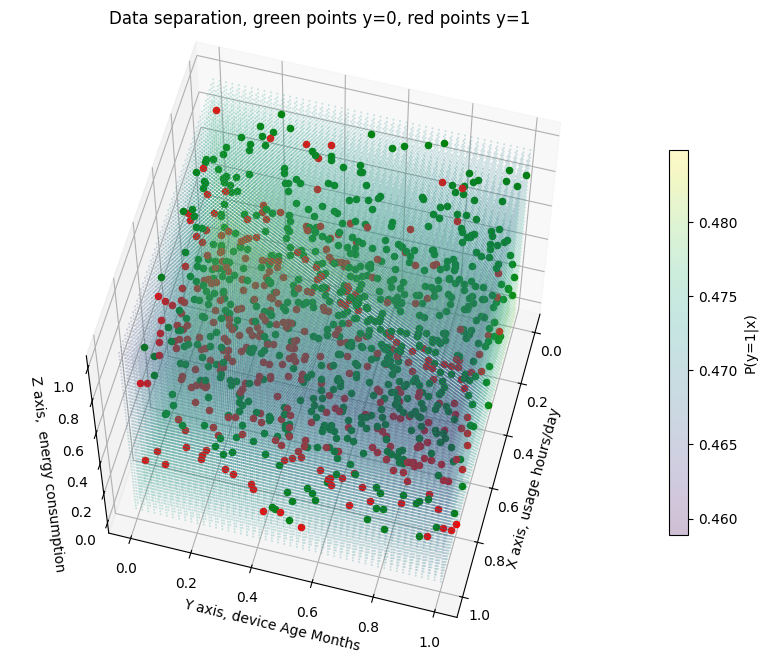

In [9]:
## P(y=1|x)
def opt_f(wstar,z):
    return 1.0 / (1.0 + np.exp(-wstar.dot(z)))

## Display separation hyperplan from wstar, bstar (optimal weights/bias)
dom_points =[0,1,0,1,0,1]
grid_size = 50

# 3D Grid
x = np.linspace(dom_points[0], dom_points[1], grid_size)
y = np.linspace(dom_points[2], dom_points[3], grid_size)
z = np.linspace(dom_points[4], dom_points[5], grid_size)
X, Y, Z = np.meshgrid(x, y, z)

## plot the separation hyperplan 
X2, Y2 = np.meshgrid(x, y)
if xlist_approx[-1][2] != 0:
    Z2 = (-xlist_approx[-1][0] * X2 - xlist_approx[-1][1] * Y2 - xlist_approx[-1][3]) / xlist_approx[-1][2]
    mask = (Z2 >= 0) & (Z2 <= 1)
    Z2[~mask] = np.nan  

# Compute P(y=1|x)
P = np.zeros((grid_size, grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        for k in range(grid_size):
            P[i, j, k] = opt_f(xlist_approx[-1], [x[i], y[j], z[k], 1.0])
            
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X2, Y2, Z2, color='cyan', alpha=0.8) #separation hyperplan

scatter = ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=P.flatten(), cmap='viridis', s=0.2, alpha=0.25) #change opacity with alpha
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
cbar.set_label("P(y=1|x)")

for i in range(n):
    if yi_list[i] == 1:
        ax.scatter(xi_list[i, 0], xi_list[i, 1], xi_list[i, 2], color="red", label="y=1" if i == 0 else "")
    else:
        ax.scatter(xi_list[i, 0], xi_list[i, 1], xi_list[i, 2], color="green", label="y=0" if i == 0 else "")

elevation_angle = 60
azimuthal_angle = 15
ax.view_init(elevation_angle, azimuthal_angle)

ax.set_xlabel("X axis, usage hours/day")
ax.set_ylabel("Y axis, device Age Months")
ax.set_zlabel("Z axis,  energy consumption")

ax.set_title(r"Data separation, green points y=0, red points y=1")
ax.set_aspect("equal", adjustable = "box") # pour que les axes aient la même échelle
fig.savefig("Logistic_" + DeviceType + ".png")
plt.show()

4. Multi-layer perceptron

Compare the results you obtained with a multi-layer perceptron (no hidden layer, one hidden layer and five hidden layers resp.).

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

############
## No hidden layer
mlp_no_hidden = MLPClassifier(hidden_layer_sizes=(), activation="logistic", solver='lbfgs', alpha=lamb, max_iter=3000000) #for comparison, use activation="logistic"
mlp_no_hidden.fit(xi_list, yi_list)
y_predict_proba = mlp_no_hidden.predict_proba(xi_list)
log_loss_no_hidden = log_loss(yi_list, y_predict_proba)
print(f"Log-loss (no hidden layer) : {log_loss_no_hidden:.4f}")

weights_no_hidden = np.array(mlp_no_hidden.coefs_)
bias_no_hidden = mlp_no_hidden.intercepts_
print(weights_no_hidden.transpose()," ", bias_no_hidden)

## Compare to our model:
our_predict_proba = opt_f(wstar, xi_list_bias.T)
log_loss_our = log_loss(yi_list, our_predict_proba)
print(f"Log-loss (our model) : {log_loss_our:.3f}")
print(xlist_approx[-1])

Log-loss (no hidden layer) : 0.5965
[[[ 1.53899936]
  [-1.50012584]
  [-1.66407453]]]   [array([0.18430263])]
Log-loss (our model) : 0.597
[-0.01874358 -0.04261229 -0.04287322 -0.0604298 ]


In [11]:
############
## One hidden layer, 3 neurons, activation=logistic 

mlp_one_hidden = MLPClassifier(hidden_layer_sizes=(3,), activation="logistic", solver='lbfgs', alpha=lamb, max_iter=3000000)
mlp_one_hidden.fit(xi_list, yi_list)
y_predict_proba = mlp_one_hidden.predict_proba(xi_list)
log_loss_one_hidden = log_loss(yi_list, y_predict_proba)
print(f"Log-loss (one layer) : {log_loss_one_hidden:.4f}")
weights_one_hidden = mlp_one_hidden.coefs_
bias_one_hidden = mlp_one_hidden.intercepts_
print(f"{weights_one_hidden=}")
print(f"{bias_one_hidden=}")
############
## Five hidden layers, 9 neurons, activation=relu

mlp_five_hidden = MLPClassifier(hidden_layer_sizes=(9,9,9), activation="relu", solver='lbfgs', alpha=lamb, max_iter=3000000)
mlp_five_hidden.fit(xi_list, yi_list)
y_predict_proba = mlp_five_hidden.predict_proba(xi_list)
log_loss_five_hidden = log_loss(yi_list, y_predict_proba)
print(f"Log-loss (5 hidden layers) : {log_loss_five_hidden:.4f}")

Log-loss (one layer) : 0.5650
weights_one_hidden=[array([[-5.44751327,  6.41550551, -7.56926403],
       [ 4.41057182,  8.46892766, -2.98761769],
       [25.48148058, -3.89726333, -1.82441715]]), array([[-2.29123728],
       [-2.23747516],
       [-2.60543465]])]
bias_one_hidden=[array([-14.60031749,  -4.74777967,   4.82003217]), array([2.38582427])]
Log-loss (5 hidden layers) : 0.5293


6. Visualization

With one layer and three neurons, compute $P(y = 1|x)$ in a function opt_f and visualize the results. You should recover the results from mlp_one_hidden.predict_proba.

In [12]:
## P(y=1|x)
def opt_f(wstar,bstar,z):
    W1 = wstar[:9].reshape(3, 3).transpose()  # Hidden layer weights (3 neurons, 3 inputs)
    W2 = wstar[9:].reshape(1, 3)  # Outputs weights (1 neuron, 3 hidden inputs)
    B1 = np.array([bstar[0],bstar[1],bstar[2]]).reshape(3,1)
    B2 = bstar[3]
    z = np.array(z).reshape(3, 1)  

    H = 1.0 / (1.0 + np.exp(-(W1.dot(z)+B1))) #hidden layer
    P = 1.0 / (1.0 + np.exp(-(W2.dot(H)+B2)))
    return P[0, 0] #carreful: must return a float 

[-5.44751327  6.41550551 -7.56926403  4.41057182  8.46892766 -2.98761769
 25.48148058 -3.89726333 -1.82441715 -2.29123728 -2.23747516 -2.60543465]
[-14.60031749  -4.74777967   4.82003217   2.38582427]


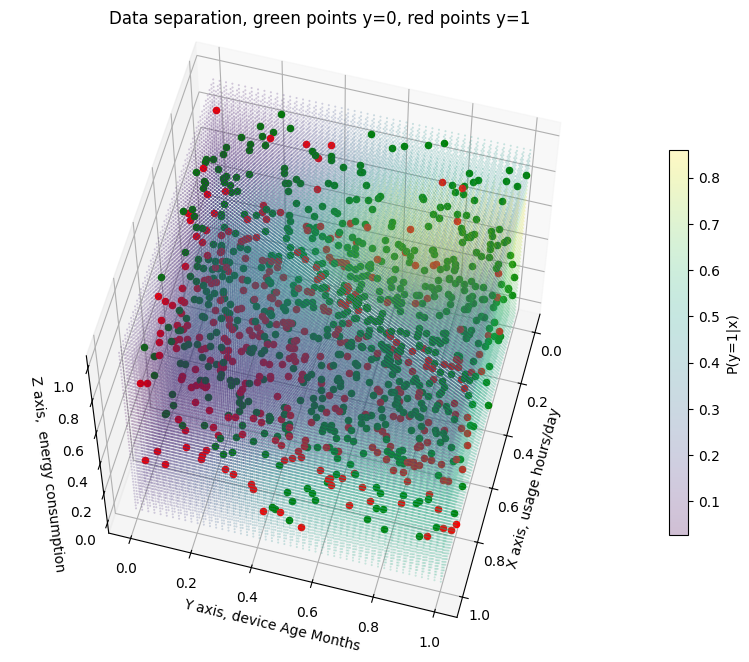

In [13]:
## Visualization with opt_f

dom_points =[0,1,0,1,0,1]
#dom_points = [0,np.max(xi_list[:, 0]), 0,np.max(xi_list[:, 1]),0,np.max(xi_list[:, 2])]#[-11, 11, -11, 11,]
grid_size = 50

# Génération de la grille 3D
x = np.linspace(dom_points[0], dom_points[1], grid_size)
y = np.linspace(dom_points[2], dom_points[3], grid_size)
z = np.linspace(dom_points[4], dom_points[5], grid_size)
X, Y, Z = np.meshgrid(x, y, z)


P = np.zeros((grid_size, grid_size,grid_size))
w_opt=np.concatenate((weights_one_hidden[0].flatten(),weights_one_hidden[1].flatten()))
print(w_opt)
b_opt=np.concatenate((bias_one_hidden[0].flatten(),bias_one_hidden[1].flatten()))
print(b_opt)
for i in range(grid_size):
    for j in range(grid_size):
        for k in range(grid_size):
            P[i, j, k] =opt_f(w_opt, b_opt, [x[i], y[j], z[k]])
            
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=P.flatten(), cmap='viridis', s=0.2, alpha=0.25)

# Barre de couleurs
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
cbar.set_label("P(y=1|x)")
for i in range(n):
    if yi_list[i] == 1:
        ax.scatter(xi_list[i, 0], xi_list[i, 1], xi_list[i, 2], color="red", label="y=1" if i == 0 else "")
    else:
        ax.scatter(xi_list[i, 0], xi_list[i, 1], xi_list[i, 2], color="green", label="y=0" if i == 0 else "")

# Légendes et étiquettes

elevation_angle = 60
azimuthal_angle = 15
ax.view_init(elevation_angle, azimuthal_angle)

ax.set_xlabel("X axis, usage hours/day")
ax.set_ylabel("Y axis, device Age Months")
ax.set_zlabel("Z axis,  energy consumption")


ax.set_title(r"Data separation, green points y=0, red points y=1")
ax.set_aspect("equal", adjustable = "box") # pour que les axes aient la même échelle
fig.savefig("OneLayer_optf_" + Prefix + ".png")
plt.show()

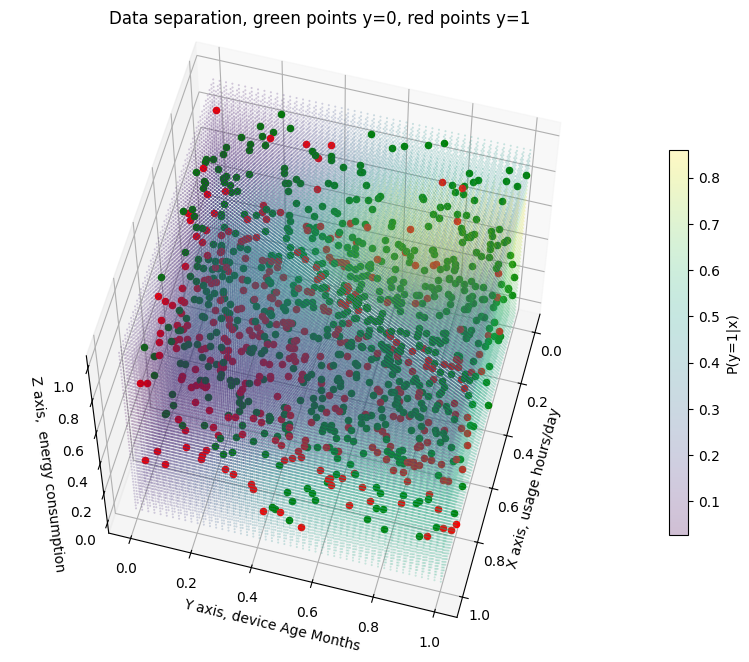

In [14]:
## Data

## Visualization with mlp_one_hidden

dom_points =[0,1,0,1,0,1]
grid_size = 50

x = np.linspace(dom_points[0], dom_points[1], grid_size)
y = np.linspace(dom_points[2], dom_points[3], grid_size)
z = np.linspace(dom_points[4], dom_points[5], grid_size)
X, Y, Z = np.meshgrid(x, y, z)

P = np.zeros((grid_size, grid_size,grid_size))

for i in range(grid_size):
    for j in range(grid_size):
        for k in range(grid_size):
            P[i, j, k] = mlp_one_hidden.predict_proba([[x[i], y[j], z[k]]])[0, 1] # with mlp_one_hidden
            
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=P.flatten(), cmap='viridis', s=0.2, alpha=0.25)
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
cbar.set_label("P(y=1|x)")
for i in range(n):
    if yi_list[i] == 1:
        ax.scatter(xi_list[i, 0], xi_list[i, 1], xi_list[i, 2], color="red", label="y=1" if i == 0 else "")
    else:
        ax.scatter(xi_list[i, 0], xi_list[i, 1], xi_list[i, 2], color="green", label="y=0" if i == 0 else "")

elevation_angle = 60
azimuthal_angle = 15
ax.view_init(elevation_angle, azimuthal_angle)

ax.set_xlabel("X axis, usage hours/day")
ax.set_ylabel("Y axis, device Age Months")
ax.set_zlabel("Z axis,  energy consumption")


ax.set_title(r"Data separation, green points y=0, red points y=1")
ax.set_aspect("equal", adjustable = "box")
fig.savefig("OneLayer_" + Prefix + ".png")
plt.show()

Conclusion: In PDF or with comments

How do the parameters seem to influence classification?

Bonus: What would you recommend to avoid overfitting? How to be more confidence in our model?